# Laboratorio 2 Machine Learning Avanzado - Red Neuronal LSTM

## Integrantes

- Sebastián Gacitúa
- Bastián Guzmán
- Jose Zamora
- Leandro Aroca
- Matthias Clein

## Librerías

In [1]:
import numpy as np
import pandas as pd
from skimage import io, color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
import os
import librosa
import librosa.display
from IPython.display import Audio
import fnmatch

2022-12-06 23:11:58.072443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Imágenes

### Carga y lectura de imágenes

Abrimos una imagen cualquiera indicándole su ruta a la función *imread*. Luego, la mostramos por pantalla con la función *imshow*. Imprimimos también las dimensiones de la imagen.

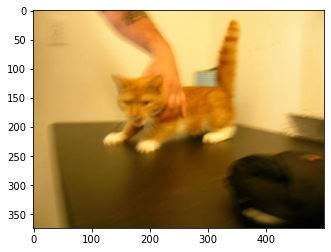

(374, 500, 3)


In [2]:
image = io.imread("../data/dogs-vs-cats/train/cat.0.jpg")
plt.imshow(image)
plt.show()
print(image.shape)

Definimos la función *generate_data* para cargar las imágenes del conjunto de entrenamiento. La función además se encargará de pasar la imagen a escala de grises y reescalar su tamaño a 200x200 pixeles, para facilitar el procesamiento y estandarizar el tamaño de las imágenes. 

In [6]:
def generate_data(num_images):
    images = []
    labels = []
    for i in range(0, num_images):
        path = "../data/dogs-vs-cats/train/cat.X.jpg"
        path = path.replace("X", str(i))
        image = io.imread(path)
        image = color.rgb2gray(image)
        image = resize(image, (200, 200), anti_aliasing = True)
        images.append(image)
        labels.append(0)

    for i in range(0, num_images):
        path = "../data/dogs-vs-cats/train/dog.X.jpg"
        path = path.replace("X", str(i))
        image = io.imread(path)
        image = color.rgb2gray(image)
        image = resize(image, (200, 200), anti_aliasing = True)
        images.append(image)
        labels.append(1)
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

Llamamos a la función *generate_data* pidiendo X imágenes de perros y gatos.

In [32]:
images, labels = generate_data(1000)

Por motivos de tiempos de entrenamiento, se realizan pruebas de funcionamiento con 2.000 datos (1.000 de c/u). Con las 25.000 imágenes (12.500 de c/u) la métrica de *accuracy* debería aumentar.

Dividimos el conjunto de imágenes y etiquetas en dos conjuntos: *train* y *test*.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)

### Red Neuronal Convolucional (CNN)

#### Modelo 1 - CNN

El primer modelo de Red Neuronal Convolucional se compone de:
- La Capa de entrada es una capa de convolución con 64 filtros de 2x2, padding *same* (rellenar con 0's) y función de activación *relu*.
- Capa de Pooling de un valor máximo con un kernel de 2x2.
- Capa de Dropout de un 30%.
- Capa de convolución con 32 filtros de 2x2, padding *same* (rellenar con 0's) y función de activación *relu*.
- Capa de Pooling de un valor máximo con un kernel de 2x2.
- Capa de Dropout de un 30%.
- Capa Flatten para *"aplanar"* el resultado.
- Capa Densa de 256 neuronas con función de activación *relu*.
- Capa de Dropout de un 50%.
- Capa de salida con una neurona y función de activación *sigmoide*.

In [34]:
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu", input_shape = (200, 200, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = 2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = 2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(1, activation = "sigmoid"))

Se imprime el resumen del modelo para conocer su cantidad de parámetros.

In [35]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 64)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 200, 200, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 batch_normalization_5 (Batc  (None, 100, 100, 32)    

Compilamos el modelo con función de pérdida de *Cross-Entropy Binaria* y optimizador *rmsprop*.

In [36]:
cnn_model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

Se realiza el entrenamiento utilizando el 80% del conjunto *(X_train, y_train)*, pues el restante 20% lo utilizamos como conjunto de validación.

In [37]:
cnn_model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_split = 0.2)

Epoch 1/10
20/20 [==============================] - 44s 2s/step - loss: 9.9181 - accuracy: 0.5109 - val_loss: 0.6893 - val_accuracy: 0.5625
Epoch 2/10
20/20 [==============================] - 42s 2s/step - loss: 5.6995 - accuracy: 0.5594 - val_loss: 0.7144 - val_accuracy: 0.5688
Epoch 3/10
20/20 [==============================] - 42s 2s/step - loss: 4.6437 - accuracy: 0.5891 - val_loss: 1.0982 - val_accuracy: 0.4812
Epoch 4/10
20/20 [==============================] - 41s 2s/step - loss: 4.5260 - accuracy: 0.6195 - val_loss: 1.2860 - val_accuracy: 0.5375
Epoch 5/10
20/20 [==============================] - 42s 2s/step - loss: 4.0039 - accuracy: 0.6570 - val_loss: 1.0650 - val_accuracy: 0.5188
Epoch 6/10
20/20 [==============================] - 42s 2s/step - loss: 3.1319 - accuracy: 0.6672 - val_loss: 1.3482 - val_accuracy: 0.4812
Epoch 7/10
20/20 [==============================] - 42s 2s/step - loss: 2.5210 - accuracy: 0.6922 - val_loss: 1.6862 - val_accuracy: 0.5219
Epoch 8/10
20/20 [==

Evaluamos el modelo pasándole el conjunto *(X_test, y_test)*.

In [38]:
cnn_model.evaluate(X_test, y_test)

13/13 [==============================] - 3s 231ms/step - loss: 0.7665 - accuracy: 0.4975


[0.7665363550186157, 0.4975000023841858]

#### Modelo 2 - CNN

El Modelo 2 se compone de:
- Capa de entrada con 32 neuronas y activación *relu*.
- Capa de Dropout de un 30%.
- Capa oculta de 64 neuronas y activación *relu*.
- Capa de Dropout de un 30%.
- Capa oculta de 128 neuronas y activación *relu*.
- Capa de Dropout de un 30%.
- Capa oculta de 128 neuronas y activación *relu*.
- Capa de Dropout de un 30%.    
- Capa oculta de 32 neuronas y activación *relu*.
- Capa de salida con 1 neurona y activación *softmax*.
- Función de pérdida: Binary Cross-Entropy.
- Optimizador *rmsprop*

In [39]:
cnn_model_2 = tf.keras.Sequential()
cnn_model_2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (200, 200, 1)))
cnn_model_2.add(MaxPooling2D(pool_size = 2))
cnn_model_2.add(Dropout(0.3))

cnn_model_2.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
cnn_model_2.add(MaxPooling2D(pool_size = 2))
cnn_model_2.add(Dropout(0.3))

cnn_model_2.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu"))
cnn_model_2.add(MaxPooling2D(pool_size = 2))
cnn_model_2.add(Dropout(0.3))

cnn_model_2.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu"))
cnn_model_2.add(MaxPooling2D(pool_size = 2))
cnn_model_2.add(Dropout(0.3))

cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(512, activation = "relu"))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(1, activation = "softmax"))

Se imprime el resumen del modelo para conocer su cantidad de parámetros.

In [40]:
cnn_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 200, 200, 32)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 50, 50, 64)       

Compilamos el modelo con función de pérdida de *Cross-Entropy Binaria* y optimizador *rmsprop*.

In [41]:
cnn_model_2.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

Se realiza el entrenamiento utilizando el 80% del conjunto *(X_train, y_train)*, pues el restante 20% lo utilizamos como conjunto de validación.

In [42]:
cnn_model_2.fit(X_train, y_train, batch_size = 20, epochs = 2, validation_split = 0.2)

Epoch 1/2
64/64 [==============================] - 29s 435ms/step - loss: 0.7526 - accuracy: 0.5070 - val_loss: 0.6917 - val_accuracy: 0.4781
Epoch 2/2
64/64 [==============================] - 28s 441ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6916 - val_accuracy: 0.4781


Evaluamos el modelo pasándole el conjunto *(X_test, y_test)*.

In [43]:
cnn_model_2.evaluate(X_test, y_test)

13/13 [==============================] - 2s 157ms/step - loss: 0.6977 - accuracy: 0.4950


[0.6977315545082092, 0.4950000047683716]

### Red Neuronal LSTM (Long Short-Term Memory)

#### Modelo 1 - LSTM

El primer modelo de Red Neuronal LSTM se compone de:
- La Capa de entrada es una capa LSTM de 64 neuronas.
- Capa de Batch Normalization.
- Capa densa de 64 neuronas y función de activación *relu*.
- Capa de Batch Normalization.
- Capa de Dropout de un 30%.
- Capa de salida con una neurona y función de activación *sigmoide*.

In [44]:
lstm_model = tf.keras.Sequential()
lstm_model.add(LSTM(64, input_shape = (200, 200)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(64, activation = "relu"))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation = "sigmoid"))

Se imprime el resumen del modelo para conocer su cantidad de parámetros.

In [45]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                67840     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

Compilamos el modelo con función de pérdida de *Cross-Entropy Binaria* y optimizador *rmsprop*.

In [46]:
lstm_model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

Se realiza el entrenamiento utilizando el 80% del conjunto *(X_train, y_train)*, pues el restante 20% lo utilizamos como conjunto de validación.

In [47]:
lstm_model.fit(X_train, y_train, batch_size = 16, epochs = 10, validation_split = 0.2)

Epoch 1/10
80/80 [==============================] - 6s 48ms/step - loss: 0.8189 - accuracy: 0.5000 - val_loss: 0.6854 - val_accuracy: 0.5719
Epoch 2/10
80/80 [==============================] - 3s 41ms/step - loss: 0.7681 - accuracy: 0.5258 - val_loss: 0.7143 - val_accuracy: 0.5156
Epoch 3/10
80/80 [==============================] - 3s 41ms/step - loss: 0.7469 - accuracy: 0.5352 - val_loss: 0.7952 - val_accuracy: 0.4812
Epoch 4/10
80/80 [==============================] - 3s 42ms/step - loss: 0.7377 - accuracy: 0.5336 - val_loss: 0.6852 - val_accuracy: 0.5437
Epoch 5/10
80/80 [==============================] - 3s 41ms/step - loss: 0.7103 - accuracy: 0.5711 - val_loss: 0.7422 - val_accuracy: 0.5156
Epoch 6/10
80/80 [==============================] - 3s 41ms/step - loss: 0.7247 - accuracy: 0.5680 - val_loss: 0.7487 - val_accuracy: 0.5125
Epoch 7/10
80/80 [==============================] - 3s 42ms/step - loss: 0.7059 - accuracy: 0.5695 - val_loss: 0.7068 - val_accuracy: 0.5688
Epoch 8/10
80

Evaluamos el modelo pasándole el conjunto *(X_test, y_test)*.

In [48]:
lstm_model.evaluate(X_test, y_test)

13/13 [==============================] - 1s 28ms/step - loss: 0.7305 - accuracy: 0.5050


[0.7305246591567993, 0.5049999952316284]

#### Modelo 2 - LSTM

El segundo modelo de Red Neuronal LSTM se compone de:
- La Capa de entrada es una capa LSTM de 64 neuronas.
- Capa densa de 128 neuronas y función de activación *relu*.
- Capa de salida con una neurona y función de activación *sigmoide*.

In [49]:
lstm_model_2 = tf.keras.Sequential()
lstm_model_2.add(LSTM(64, input_shape = (200, 200)))
lstm_model_2.add(Dense(128, activation='relu'))
lstm_model_2.add(Dense(1, activation='sigmoid'))

Se imprime el resumen del modelo para conocer su cantidad de parámetros.

In [50]:
lstm_model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                67840     
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 76,289
Trainable params: 76,289
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo con función de pérdida de *Cross-Entropy Binaria* y optimizador *Adam*.

In [51]:
lstm_model_2.compile(optimizer = Adam(),  loss = 'binary_crossentropy',   metrics = 'accuracy')

Se realiza el entrenamiento utilizando el 80% del conjunto *(X_train, y_train)*, pues el restante 20% lo utilizamos como conjunto de validación.

In [52]:
lstm_model.fit(X_train, y_train, batch_size = 20, epochs = 2, validation_split = 0.2)

Epoch 1/2
64/64 [==============================] - 6s 70ms/step - loss: 0.6703 - accuracy: 0.5867 - val_loss: 0.7314 - val_accuracy: 0.5500
Epoch 2/2
64/64 [==============================] - 3s 54ms/step - loss: 0.6663 - accuracy: 0.6039 - val_loss: 0.7018 - val_accuracy: 0.5312


Evaluamos el modelo pasándole el conjunto *(X_test, y_test)*.

In [53]:
lstm_model_2.evaluate(X_test, y_test)

13/13 [==============================] - 1s 28ms/step - loss: 0.6938 - accuracy: 0.4850


[0.6937773823738098, 0.48500001430511475]

### Predicciones

Ahora es momento de probar los cuatro modelos implementados. Para eso cargaremos imágenes propias, las cuales deben ser procesadas de la misma forma que las imágenes de entrenamiento, es decir, pasarla a escala de grises, redimensionarla a 200x200 pixeles y guardarla en un arreglo de numpy.

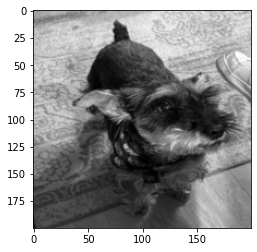

In [54]:
test_image = io.imread("../data/test/flopy.jpg")
test_image = color.rgb2gray(test_image)
test_image = resize(test_image, (200, 200), anti_aliasing = True)
plt.imshow(test_image, cmap = "gray")
plt.show()
test_image = np.array([test_image])

Luego se utiliza el método *predict* de cada modelo para realizar una predicción. El valor resultante se redondea para obtener un valor de 0 o 1 y dependiendo de eso se imprime por pantalla si fue clasificado como Perro (1) o Gato (0).

In [56]:
print("Modelo CNN 1:", "Perro" if int(round(cnn_model.predict(test_image, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo CNN 2:", "Perro" if int(round(cnn_model_2.predict(test_image, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo LSTM 1:", "Perro" if int(round(lstm_model.predict(test_image, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo LSTM 2:", "Perro" if int(round(lstm_model_2.predict(test_image, verbose = False)[0][0],0)) == 1 else "Gato")

Modelo CNN 1: Gato
Modelo CNN 2: Perro
Modelo LSTM 1: Gato
Modelo LSTM 2: Gato


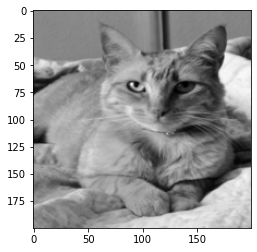

In [57]:
test_image_2 = io.imread("../data/test/fede.jpg")
test_image_2 = color.rgb2gray(test_image_2)
test_image_2 = resize(test_image_2, (200, 200), anti_aliasing = True)
plt.imshow(test_image_2, cmap = "gray")
plt.show()
test_image_2 = np.array([test_image_2])

In [58]:
print("Modelo CNN 1:", "Perro" if int(round(cnn_model.predict(test_image_2, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo CNN 2:", "Perro" if int(round(cnn_model_2.predict(test_image_2, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo LSTM 1:", "Perro" if int(round(lstm_model.predict(test_image_2, verbose = False)[0][0],0)) == 1 else "Gato")
print("Modelo LSTM 2:", "Perro" if int(round(lstm_model_2.predict(test_image_2, verbose = False)[0][0],0)) == 1 else "Gato")

Modelo CNN 1: Gato
Modelo CNN 2: Perro
Modelo LSTM 1: Gato
Modelo LSTM 2: Gato


## Audio

El conjunto de datos consiste archivos "wav" para las clases de gatos y perros:

-  cat tiene 164 archivos WAV a los que corresponden 1323 segundos de audio.
-  dog tiene 113 archivos WAV a los que corresponden 598 segundos de audio.

Todos los archivos WAV contienen audio de 16 KHz y tienen una duración variable.

In [158]:
ID = []
label = []
directory = '../data/audio-cats-and-dogs/cats_dogs/train/'

for folder in os.listdir(directory):                             
    for filename in os.listdir(directory+str(folder)):      
        f = os.path.join(directory+str(folder), filename)
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

Creamos un DataFrame con el *id* (nombre del archivo) y su respectiva *label*.

In [159]:
train_data = pd.DataFrame()
train_data['ID'] = ID
train_data['label'] = label

In [160]:
train_data

,ID,label
0,cat_74.wav,cat
1,cat_60.wav,cat
2,cat_48.wav,cat
3,cat_132.wav,cat
4,cat_127.wav,cat
...,...,...
205,dog_barking_84.wav,dog
206,dog_barking_102.wav,dog
207,dog_barking_103.wav,dog
208,dog_barking_85.wav,dog


Graficamos la cantidad de perros y gatos que tiene el conjunto.

/Users/matthiascleinespinoza/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


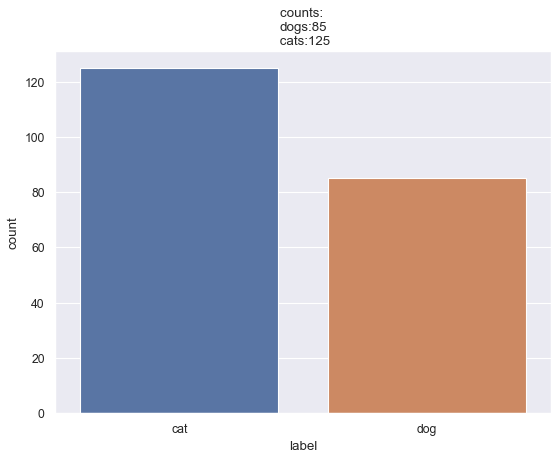

In [161]:
plt.figure(figsize = (8,6), dpi = 80)
sns.set_theme(style = "darkgrid")
sns.countplot('label',data = train_data)
plt.title('counts: \n' +'dogs:'+str(train_data.label.value_counts()[1])+'\n cats:'+str(train_data.label.value_counts()[0]))
plt.show()

Hacemos lo mismo para el conjunto de *test*.

In [162]:
ID = []
label = []
import os
directory = '../data/audio-cats-and-dogs/cats_dogs/test/'

for folder in os.listdir(directory):
    for filename in os.listdir(directory+str(folder)):
        f = os.path.join(directory+str(folder), filename)
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

In [163]:
test_data = pd.DataFrame()
test_data['ID'] = ID
test_data['label'] = label
test_data

test_data[test_data['label'] == 'test'] = 'dogs'
test_data

,ID,label
0,cat_126.wav,cats
1,cat_133.wav,cats
2,cat_61.wav,cats
3,cat_75.wav,cats
4,cat_88.wav,cats
...,...,...
62,dogs,dogs
63,dogs,dogs
64,dogs,dogs
65,dogs,dogs


### Reproducir audios aleatorios de gatos y perros

In [164]:
cat_train_directory = '../data/audio-cats-and-dogs/cats_dogs/train/cat/'
cat_random_dir = train_data[train_data['label']=='cat'].sample()['ID'].values[0] #Obtiene un ID(directorio) aleatorio donde la eqtiqueta es cat

cat_dir_example=cat_train_directory + cat_random_dir
cat_sample_data, cat_sample_rate = librosa.load(cat_dir_example)
Audio(data=cat_sample_data,rate=cat_sample_rate)

In [165]:
dog_train_directory = '../data/audio-cats-and-dogs/cats_dogs/train/dog/'
dog_random_dir = train_data[train_data['label']=='dog'].sample()['ID'].values[0] #Obtiene un ID(directorio) aleatorio donde la eqtiqueta es cat

dog_dir_example=dog_train_directory + dog_random_dir

dog_sample_data, dog_sample_rate = librosa.load(dog_dir_example)
Audio(data=dog_sample_data,rate=dog_sample_rate)

### Forma de onda

El sonido es la presión del aire que se propaga a nuestro oído. El archivo de audio digital se obtiene de un sensor de sonido que puede detectar ondas de sonido y convertirlas en señales eléctricas.

Específicamente, nos informa sobre el desplazamiento de la onda y cómo cambia con el tiempo.

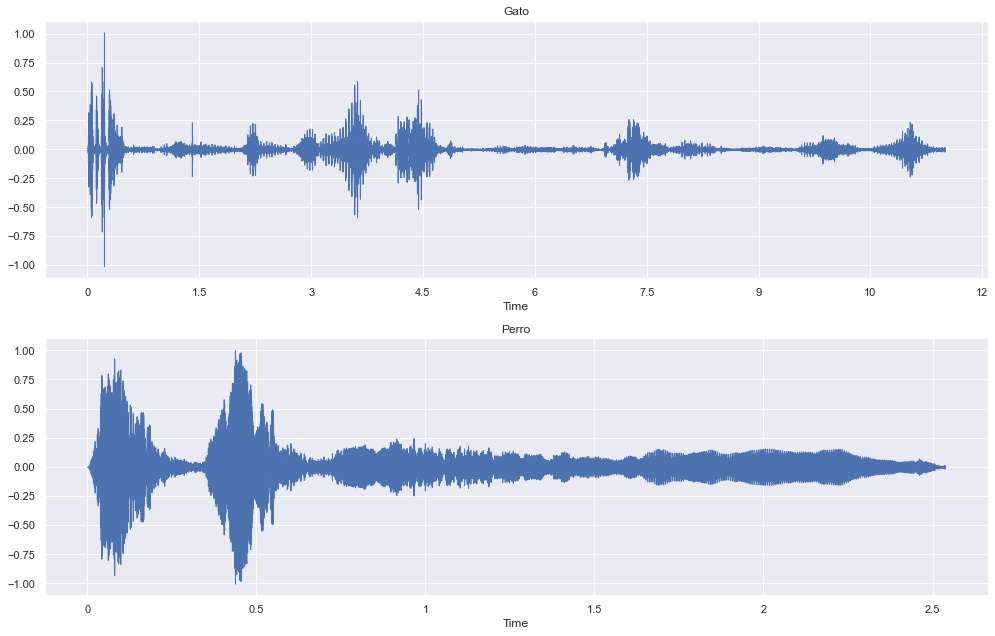

In [166]:
plt.figure(figsize=(14, 9))

fig = plt.figure(1)

plt.subplot(2,1,1) 
plt.title('Gato')
librosa.display.waveshow(cat_sample_data, sr = cat_sample_rate)

plt.subplot(2,1,2) 
plt.title('Perro')
librosa.display.waveshow(dog_sample_data, sr = dog_sample_rate)

fig.tight_layout()
plt.show()

### Espectro

Un espectro de sonido es una representación de un sonido, generalmente una pequeña muestra de un sonido, en términos de la cantidad de vibración en cada frecuencia individual. Por lo general, se presenta como un gráfico de potencia o presión en función de la frecuencia. La potencia o presión suele medirse en decibelios y la frecuencia se mide en vibraciones por segundo (o hercios, abreviatura Hz) o miles de vibraciones por segundo (kilohercios, abreviatura kHz).

El espectro expresa la composición de frecuencias del sonido y se obtiene analizando el sonido. Un espectro de sonido generalmente se representa en un plano de coordenadas donde la frecuencia f se traza a lo largo del eje de abscisas y la amplitud A, o intensidad, de un componente armónico con una frecuencia dada se traza a lo largo del eje de ordenadas.

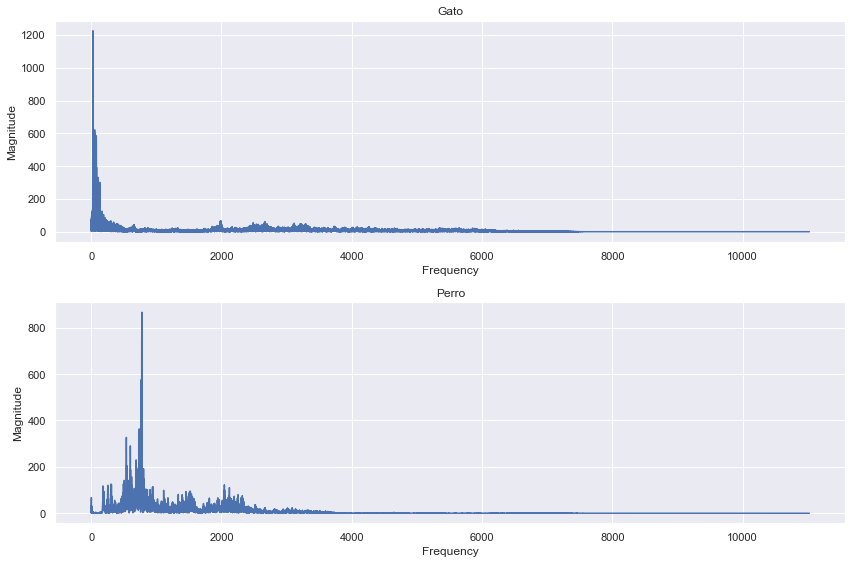

In [167]:
def espectro(sample_data, sample_rate):
  fft_normal = np.fft.fft(sample_data)
  magnitude_normal = np.abs(fft_normal)
  freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
  half_freq = freq_normal[:int(len(freq_normal)/2)]
  half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]
  return half_freq, half_magnitude

cat_half_freq, cat_half_magnitud = espectro(cat_sample_data, cat_sample_rate)
dog_half_freq, dog_half_magnitud = espectro(dog_sample_data, dog_sample_rate)

plt.figure(figsize=(12, 8))
fig = plt.figure(1)

plt.subplot(2,1,1)  # (nrows, ncols, index)
plt.plot(cat_half_freq,cat_half_magnitud)
plt.title('Gato')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2,1,2) #(nrows, ncols, index)
plt.plot(dog_half_freq,dog_half_magnitud)
plt.title('Perro')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

fig.tight_layout()
plt.show()

### Espectrograma

Para nosotros, como humanos, percibimos un sonido no solo en un momento determinado por su intensidad, sino también por su tono. El tono es la frecuencia del sonido: un tono más alto corresponde a una frecuencia más alta y viceversa. Entonces, para tener una representación más cercana a nuestro cerebro, podemos agregar otra dimensión, la frecuencia, a nuestra representación, que es el Espectrograma.

Un espectrograma es una representación visual del espectro de frecuencias de una señal a medida que varía con el tiempo. Cuando se aplican a una señal de audio, los espectrogramas a veces se denominan ecografías, huellas de voz o diagramas de voz.

Los espectrogramas se utilizan ampliamente en los campos de la música, la lingüística, el sonar, el radar, el procesamiento del habla, la sismología y otros. Los espectrogramas de audio se pueden usar para identificar fonéticamente las palabras habladas y para analizar las diversas llamadas de los animales. Se pueden generar mediante un espectrómetro óptico, un banco de filtros de paso de banda, mediante la transformada de Fourier o mediante una transformada de ondas.

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s
STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/2521653102.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/2521653102.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


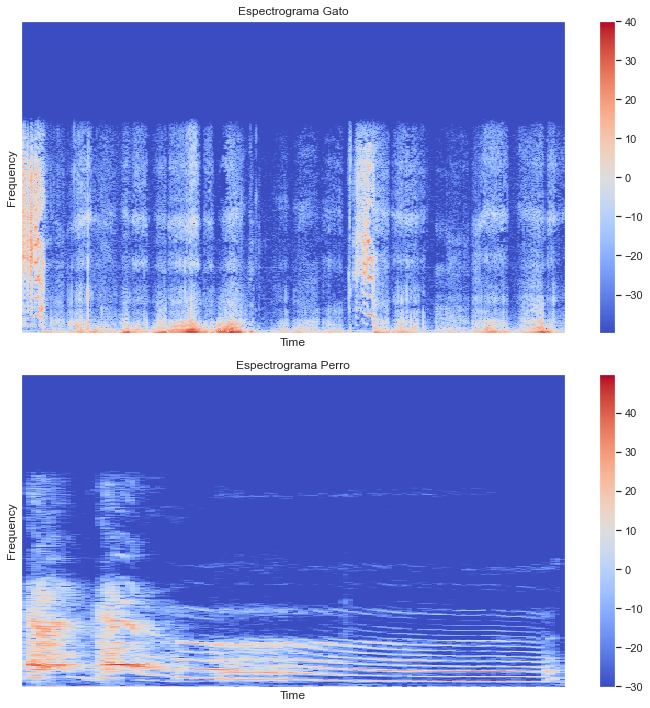

In [168]:
def espectrograma(sample_data,sample_rate):
  hop_length = 512
  n_fft = 2048 

  hop_length_duration = float(hop_length)/sample_rate
  n_fft_duration = float(n_fft)/sample_rate

  print("STFT hop length duration is: {}s".format(hop_length_duration))
  print("STFT window duration is: {}s".format(n_fft_duration))

  stft_normal = librosa.stft(sample_data, n_fft=n_fft, hop_length=hop_length)

  spectrogram = np.abs(stft_normal)
  log_spectrogram = librosa.amplitude_to_db(spectrogram)
  return log_spectrogram, hop_length

cat_log_spectrogram, cat_hop_length = espectrograma(cat_sample_data, cat_sample_rate)
dog_log_spectrogram, dog_hop_length = espectrograma(dog_sample_data, dog_sample_rate)

plt.figure(figsize=(10, 10))
fig = plt.figure(1)

plt.subplot(2,1,1)  
librosa.display.specshow(cat_log_spectrogram, sr=cat_sample_rate, hop_length=cat_hop_length)
plt.title("Espectrograma Gato")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()


plt.subplot(2,1,2) 
librosa.display.specshow(dog_log_spectrogram, sr=dog_sample_rate, hop_length=dog_hop_length)
plt.title("Espectrograma Perro")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()

fig.tight_layout()
plt.show()

Tenemos una imagen que representa un sonido. El eje X es para el tiempo, el eje Y es para la frecuencia y el color es para la intensidad.

### MFCCS

No podemos tomar la señal de audio sin procesar como entrada para nuestro modelo porque habrá mucho ruido en la señal de audio. Se observa que extraer características de la señal de audio y usarla como entrada para el modelo base producirá un rendimiento mucho mejor que considerar directamente la señal de audio sin procesar como entrada. MFCC es la técnica ampliamente utilizada para extraer las características de la señal de audio.

En el procesamiento de sonido, el cepstrum de frecuencia mel (MFC) es una representación del espectro de potencia a corto plazo de un sonido, basado en una transformada de coseno lineal de un espectro de potencia logarítmica en una escala de frecuencia mel no lineal.

Los coeficientes cepstrales de frecuencia Mel (MFCC) son coeficientes que en conjunto forman un MFC. Se derivan de un tipo de representación cepstral del clip de audio (un "espectro de un espectro" no lineal). La diferencia entre el cepstrum y el cepstrum de frecuencia mel es que en el MFC, las bandas de frecuencia están igualmente espaciadas en la escala mel, que se aproxima más a la respuesta del sistema auditivo humano que las bandas de frecuencia espaciadas linealmente utilizadas en el espectro normal. Esta deformación de frecuencia puede permitir una mejor representación del sonido, por ejemplo, en la compresión de audio.

Los MFCC se derivan comúnmente de la siguiente manera:

1- Tome la transformada de Fourier de (un extracto en ventana de) una señal.

2- Mapee las potencias del espectro obtenido arriba en la escala de mel, utilizando ventanas superpuestas triangulares o, alternativamente, ventanas superpuestas de coseno.

3- Tomar los registros de las potencias en cada una de las frecuencias mel.

4- Tomar la transformada de coseno discreta de la lista de potencias logarítmicas de mel, como si fuera una señal.

5- Los MFCCs son las amplitudes del espectro resultante.

/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/2809558078.py:3: FutureWarning: Pass y=[ 0.00201321  0.00082112  0.0010046  ... -0.00429459 -0.00546819
 -0.00403759], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  cat_MFCCs = librosa.feature.mfcc(cat_sample_data, cat_sample_rate, n_fft=n_fft, hop_length=cat_hop_length, n_mfcc=n_mfcc)
/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/2809558078.py:4: FutureWarning: Pass y=[-1.7027951e-05 -4.8488699e-05 -1.3277734e-04 ...  9.4187900e-04
 -4.6375685e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  dog_MFCCs = librosa.feature.mfcc(dog_sample_data, dog_sample_rate, n_fft=n_fft, hop_length=dog_hop_length, n_mfcc=n_mfcc)
/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/2809558078.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolor

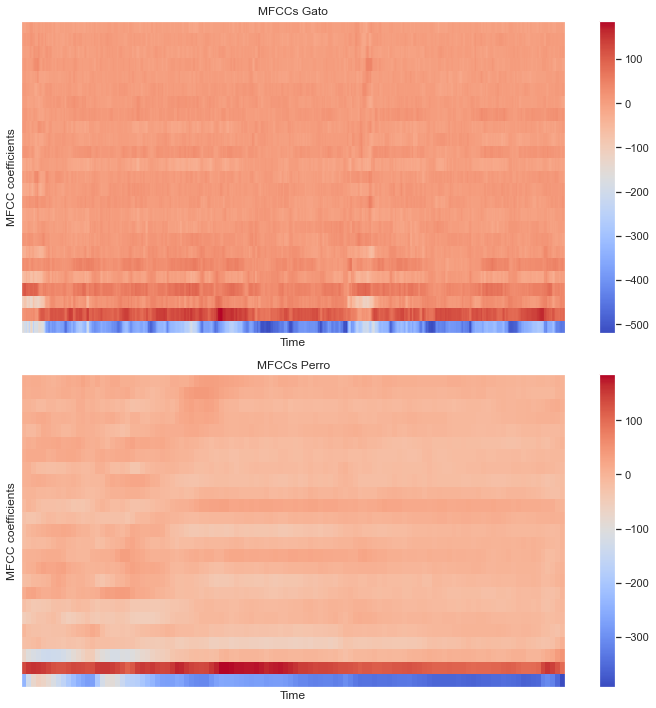

In [169]:
n_fft = 2048
n_mfcc = 25
cat_MFCCs = librosa.feature.mfcc(cat_sample_data, cat_sample_rate, n_fft=n_fft, hop_length=cat_hop_length, n_mfcc=n_mfcc)
dog_MFCCs = librosa.feature.mfcc(dog_sample_data, dog_sample_rate, n_fft=n_fft, hop_length=dog_hop_length, n_mfcc=n_mfcc)

plt.figure(figsize=(10, 10))
fig = plt.figure(1)

plt.subplot(2,1,1)  
librosa.display.specshow(cat_MFCCs, sr=cat_sample_rate, hop_length=cat_hop_length)
plt.title("MFCCs Gato")
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()

plt.subplot(2,1,2) 
librosa.display.specshow(dog_MFCCs, sr=dog_sample_rate, hop_length=dog_hop_length)
plt.title("MFCCs Perro")
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()

fig.tight_layout()
plt.show()

### Cargar data

La siguiente función se repite en cada archivo de audio y extrae las características de MFCC y la salida es una matriz numpy que contiene estos MFCC.

In [170]:
n_mfcc=25
def load_file_data (folder, file_names, duration=10, sr=22050):
    input_length=sr*duration
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [171]:
SAMPLE_RATE = 22050
MAX_SOUND_CLIP_DURATION=10

cat_train_directory = '../data/audio-cats-and-dogs/cats_dogs/train/cat/'
dog_train_directory = '../data/audio-cats-and-dogs/cats_dogs/train/dog/'

cat_train_files = fnmatch.filter(os.listdir(cat_train_directory), 'cat_*.wav')
cat_train_sounds = load_file_data (folder=cat_train_directory, file_names = cat_train_files, duration=MAX_SOUND_CLIP_DURATION)
cat_train_labels = [0 for items in cat_train_files] 

dog_train_files = fnmatch.filter(os.listdir(dog_train_directory), 'dog_barking_*.wav')
dog_train_sounds = load_file_data (folder=dog_train_directory, file_names = dog_train_files, duration=MAX_SOUND_CLIP_DURATION)
dog_train_labels = [1 for items in dog_train_files] 

cat_test_directory = '../data/audio-cats-and-dogs/cats_dogs/test/cats/'
dog_test_directory = '../data/audio-cats-and-dogs/cats_dogs/test/test/'

cat_test_files = fnmatch.filter(os.listdir(cat_test_directory), 'cat_*.wav')
cat_test_sounds = load_file_data (folder=cat_test_directory, file_names = cat_test_files, duration=MAX_SOUND_CLIP_DURATION)
cat_test_labels = [0 for items in cat_test_files] 

dog_test_files = fnmatch.filter(os.listdir(dog_test_directory), 'dog_barking_*.wav')
dog_test_sounds = load_file_data (folder=dog_test_directory, file_names = dog_test_files, duration=MAX_SOUND_CLIP_DURATION)
dog_test_labels = [1 for items in dog_test_files] 

load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_74.wav
fixing audio lenght : cat_74.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_60.wav


/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/169350432.py:13: FutureWarning: Pass size=220500 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(X, input_length)


load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_48.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_132.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_127.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_49.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_9.wav
fixing audio lenght : cat_9.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_63.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_77.wav
fixing audio lenght : cat_77.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_131.wav
fixing audio lenght : cat_131.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_125.wav
fixing audio lenght : cat_125.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_119.wav
fixing audio lenght : cat_119.wav
load file  ../data/audio-cats-and-dogs/cats_dogs/train/cat/cat_118.wav
fixing audio lenght : cat_118.wav
load file  ../data/audio

In [172]:
print("cat_train_files:",len(cat_train_files))
print("cat_train_sounds:",len(cat_train_sounds))
print("cat_train_labels:",len(cat_train_labels))

print("dog_train_files:",len(dog_train_files))
print("dog_train_sounds:",len(dog_train_sounds))
print("dog_train_labels:",len(dog_train_labels))


print("cat_test_files:",len(cat_test_files))
print("cat_test_sounds:",len(cat_test_sounds))
print("cat_test_labels:",len(cat_test_labels))

print("dog_test_files:",len(dog_test_files))
print("dog_test_sounds:",len(dog_test_sounds))
print("dog_test_labels:",len(dog_test_labels))

cat_train_files: 125
cat_train_sounds: 125
cat_train_labels: 125
dog_train_files: 85
dog_train_sounds: 85
dog_train_labels: 85
cat_test_files: 39
cat_test_sounds: 39
cat_test_labels: 39
dog_test_files: 28
dog_test_sounds: 28
dog_test_labels: 28


In [173]:
pre_x_train = np.concatenate((cat_train_sounds,dog_train_sounds))
y_train = np.concatenate((cat_train_labels,dog_train_labels))

pre_x_test = np.concatenate((cat_test_sounds,dog_test_sounds))
y_test = np.concatenate((cat_test_labels,dog_test_labels))

### Reshape de los datos

In [174]:
print("Registros de entrenamiento:",len(pre_x_train))
print("Registros de test:",len(pre_x_test))
X_train = pd.DataFrame(np.reshape(pre_x_train,(len(pre_x_train),n_mfcc)))
X_test = pd.DataFrame(np.reshape(pre_x_test,(len(pre_x_test),n_mfcc)))
print(X_train)
print(X_test)

Registros de entrenamiento: 210
Registros de test: 67
             0           1           2          3          4          5   \
0   -279.183380  109.445709  -25.578682  60.300438 -24.518944  36.602470   
1   -385.029083  132.538086   29.516941  15.119598  15.168480  23.523148   
2   -343.255096   93.975357  -37.261955 -50.886959  -2.111196  19.562653   
3   -284.200745   90.103546  -29.856213   8.282153 -28.082863  12.119233   
4   -349.212372   33.440624 -104.296600  56.407063 -43.084698  29.611883   
..          ...         ...         ...        ...        ...        ...   
205 -342.589600  122.060303  -53.798374 -33.425316  -5.280867 -15.595124   
206 -245.506210  158.694550   21.001387  54.754639  -9.954894  14.151094   
207 -256.436310  121.111679  -55.728188 -25.160608 -42.001976   2.944852   
208 -246.177933  173.745773  -11.215417 -22.934629 -17.677572 -15.964639   
209 -300.874146  161.216476  -27.036406 -17.121735 -10.626184  -3.068099   

            6          7         

### Normalización de los datos

In [175]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(X_train)
print(X_train.describe())

           0         1         2         3         4         5         6   \
0    0.452259  0.458861  0.583333  0.858336  0.444769  0.742392  0.619755   
1    0.187515  0.579978  0.863253  0.521650  0.825620  0.624372  0.987547   
2    0.292001  0.377721  0.523974  0.029772  0.659800  0.588635  0.560282   
3    0.439709  0.357414  0.561600  0.470698  0.410569  0.521470  0.582892   
4    0.277101  0.060224  0.183397  0.829322  0.266607  0.679313  0.238927   
..        ...       ...       ...       ...       ...       ...       ...   
205  0.293666  0.525024  0.439959  0.159895  0.629383  0.271393  0.441968   
206  0.536493  0.717166  0.819988  0.817009  0.584529  0.539805  0.732122   
207  0.509155  0.520048  0.430155  0.221484  0.276997  0.438687  0.456739   
208  0.534813  0.796107  0.656307  0.238072  0.510421  0.268059  0.587983   
209  0.398005  0.730393  0.575927  0.281389  0.578088  0.384429  0.724281   

           7         8         9   ...        15        16        17  \
0  

### Red Neuronal LSTM

El modelo de Red Neuronal LSTM se compone de:

*   La Capa de entrada es una capa LSTM de 256 neuronas, Dropout de 30% y return_sequences = True.
*   Capa Dense de 256 neuronas y activación *relu*.
*   Capa de BatchNormalization.
*   Capa de Dropout de 20%.
*   Capa Dense de 128 neuronas y activación *relu*.
*   Capa Dense de 128 neuronas y activación *relu*.
*   Capa de Dropout de 20%.
*   Capa de Batch Normalization.
*   Capa Dense de 64 neuronas y activación *relu*.
*   Capa de Flatten.
*   Capa de salida con una neurona y función de activación *sigmoid*.

In [176]:
n_mfcc=25
model = tf.keras.Sequential()
model.add(LSTM(256, dropout = 0.3, return_sequences=True, input_shape = (n_mfcc, 1)))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [177]:
model.compile(loss='binary_crossentropy', optimizer = Adam(1e-4), metrics = ['acc'])

In [178]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 25, 256)           264192    
                                                                 
 dense_34 (Dense)            (None, 25, 256)           65792     
                                                                 
 batch_normalization_16 (Bat  (None, 25, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 25, 256)           0         
                                                                 
 dense_35 (Dense)            (None, 25, 128)           32896     
                                                                 
 dense_36 (Dense)            (None, 25, 128)           16512     
                                                     

In [179]:
epochs_ = 100           
batch_size_ = 16  
history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_size_, validation_split = 0.2)
train_acc_model = model.evaluate(X_train, y_train, batch_size=batch_size_)[1]
test_acc_model = model.evaluate(X_test, y_test, batch_size=batch_size_)[1]
print('Training accuracy: %s' % train_acc_model)
print('Testing accuracy: %s' % test_acc_model)

Epoch 1/100
11/11 [==============================] - 5s 89ms/step - loss: 0.6069 - acc: 0.7143 - val_loss: 0.7035 - val_acc: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 32ms/step - loss: 0.5134 - acc: 0.7798 - val_loss: 0.7060 - val_acc: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 31ms/step - loss: 0.5034 - acc: 0.7679 - val_loss: 0.7067 - val_acc: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 0s 33ms/step - loss: 0.5299 - acc: 0.7560 - val_loss: 0.7107 - val_acc: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 0s 32ms/step - loss: 0.5027 - acc: 0.7738 - val_loss: 0.7108 - val_acc: 0.0000e+00
Epoch 6/100
11/11 [==============================] - 0s 32ms/step - loss: 0.4461 - acc: 0.8095 - val_loss: 0.7095 - val_acc: 0.0000e+00
Epoch 7/100
11/11 [==============================] - 0s 32ms/step - loss: 0.4380 - acc: 0.7738 - val_loss: 0.7122 - val_acc: 0.0000e+00
Epoch 8/100
11/11 [=============================

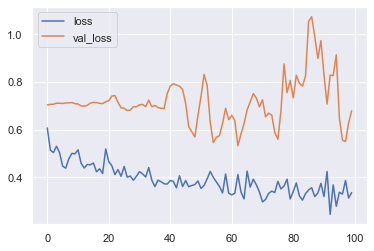

In [180]:
model_history = pd.DataFrame(history.history)
model_history[['loss','val_loss']].plot()
plt.show()

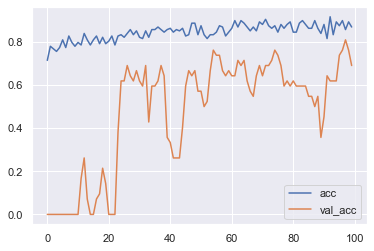

In [181]:
model_history[['acc','val_acc']].plot()
plt.show()

## Predicción de una grabación de ladridos de un perro

In [182]:
n_mfcc = 25 
folder = '../data/audio-cats-and-dogs/cats_dogs/' 
file_name = ['perro_5.wav'] 

dog_sample_data, dog_sample_rate = librosa.load(folder + file_name[0])
Audio(data = dog_sample_data, rate = dog_sample_rate)

In [183]:
mfcc_file = load_file_data (folder=folder, file_names = file_name, duration=MAX_SOUND_CLIP_DURATION)
mfcc_file = pd.DataFrame(np.reshape(mfcc_file,(len(mfcc_file),n_mfcc)))
mfcc_file = scaler.transform(mfcc_file)
prediction = model.predict(mfcc_file,verbose=0)
prediction=prediction[0][0]*100

if(prediction>50):
  print("Es perro, con una certeza de:",round(prediction,2),'%')
else:
  print("Es gato, con una certeza de:",round(prediction,2),'%')

load file  ../data/audio-cats-and-dogs/cats_dogs/perro_5.wav
fixing audio lenght : perro_5.wav


/var/folders/vg/rrvy5r0s275_mqld96rv7s9r0000gn/T/ipykernel_1207/169350432.py:13: FutureWarning: Pass size=220500 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(X, input_length)


Es perro, con una certeza de: 57.19 %


In [184]:
def escalamiento(x,in_min,in_max,out_min,out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

if(prediction>50):
  print("Es perro, con una certeza de:",round(prediction,2),'%')
else:
  prediction=escalamiento(prediction,0,50,100,50)
  print("Es gato, con una certeza de:",round(prediction,2),'%')

Es perro, con una certeza de: 57.19 %
